# Topic modelling notebook

In [1]:
import pandas as pd
import numpy as np
import psycopg2
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import seaborn as sns
import pickle

### Loading the dataset
We use two datasets to give to the model true and false cooking sentences (each one with its taret) 
* our recipes steps
* foreing text

In [2]:
# load the dataset
other_data = open('corpus.txt').readlines()
print(f"other data count: {len(other_data)}")

conn = psycopg2.connect(
    host="157.230.24.228",
    database="cookix_db",
    user="cookix_user_db",
    password="f9d6UVP6gxEqueopMCiKdpjC0A5Pi5Ww",
)
cursor = conn.cursor()

cursor.execute("SELECT steps FROM recipes_recipe;")
recipes_steps = cursor.fetchall()
recipes_steps = [steps[0] for steps in recipes_steps]
recipes_steps = [steps for steps in recipes_steps if steps.strip() != ""]
print(f"steps recipes count: {len(recipes_steps)}" )

cursor.execute("SELECT ingredients FROM recipes_recipe;")
recipes_ingredients = cursor.fetchall()
recipes_ingredients = [ings[0] for ings in recipes_ingredients]
recipes_ingredients = [ings for ings in recipes_ingredients if ings.strip() != ""]
print(f"ingredients recipes count: {len(recipes_ingredients)}" )

other data count: 10000
steps recipes count: 10303
ingredients recipes count: 22401


## join the data together

In [3]:
x_data = other_data + recipes_steps + recipes_ingredients
y_data = list(np.zeros((len(other_data)), dtype="int")) + list(np.ones((len(recipes_steps)+len(recipes_ingredients)), dtype="int"))

print(len(x_data))
print(len(y_data))

# x_data = x_data[:30]
# y_data = y_data[:30]

42704
42704


# Feature engineering

In [4]:
lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer("english")

def preprocess_text(sentences: list):
    
    processed_sen = []
    all_words = []
    
    stop_words = set(stopwords.words('english'))
    
    for sen in tqdm(sentences):
        # keep only text
        sentence = re.sub(r"[^a-z, ]+", ' ', sen.lower())
        sentence = re.sub(r'\b\w\b', ' ', sentence.strip())
        # Removing multiple spaces
        sentence = re.sub(r'\s+', ' ', sentence.strip())
        # remove stopwords
        sen_tokens = [w for w in sentence.split(" ") if w not in stop_words]
        sentence = " ".join(sen_tokens)

        processed_sen.append(sentence) 

    return processed_sen

x_data_processed = preprocess_text(x_data)

100%|██████████| 42704/42704 [00:02<00:00, 19176.81it/s]


### Count vectorizer & TF-IDF

In [5]:
vectorizer = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
x_data_vec = vectorizer.fit_transform(x_data_processed)
# print(vectorizer.get_feature_names())
# x_data_vec.toarray()

In [6]:
tfidf = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
xdata_tfidf = tfidf.fit_transform(x_data_processed)

print("output shape (sentences_count, features_count): ", xdata_tfidf.shape)

with open("tfidf.pickle", 'wb') as file:
        pickle.dump(tfidf, file, protocol=pickle.HIGHEST_PROTOCOL)

output shape (sentences_count, features_count):  (42704, 5000)


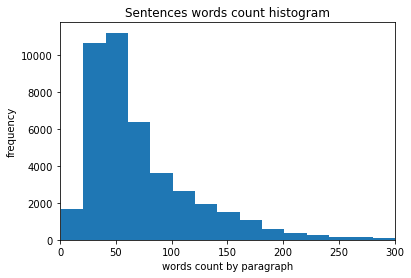

In [14]:
lengths = [len(sen.split(" ")) for sen in x_data]
w = 20
bins = math.ceil((max(lengths) - min(lengths))/w) # create bins of w
plt.hist(lengths, bins=bins)
plt.xlim((0,300))
plt.xlabel("words count by paragraph")
plt.ylabel("frequency")
plt.title("Sentences words count histogram")
plt.show()

## Training the model
* We will try different models, then choose the best of them

#### preparing data for ML

In [15]:
train_x, test_x, train_y, test_y = train_test_split(xdata_tfidf, y_data,
                                                   test_size=0.1, random_state=42)

print(f"train shape: {train_x.shape}")
print(f"test shape: {test_x.shape}")

train shape: (38433, 5000)
test shape: (4271, 5000)


In [17]:
def train_model(classifier):
    # fit the training dataset on the classifier
    classifier = classifier.fit(train_x, train_y)
    
    # predict the labels on validation dataset
    y_pred = classifier.predict(test_x)
    cm = metrics.confusion_matrix(test_y, y_pred)
    # confusion matrix
    print(f"model accuracy: {round(metrics.accuracy_score(y_pred, test_y), 3)}")
    ax = sns.heatmap(cm, annot=True, fmt="d", cbar=False, cmap="YlGnBu")
    ax.set_title("Confusion matrix")
    plt.show()
    
    return classifier


def save_classifier(model, name="topic_model.pickle"):
    
    with open(name, 'wb') as file:
        pickle.dump(model, file, protocol=pickle.HIGHEST_PROTOCOL)


#### Naive Bayes

model accuracy: 0.999


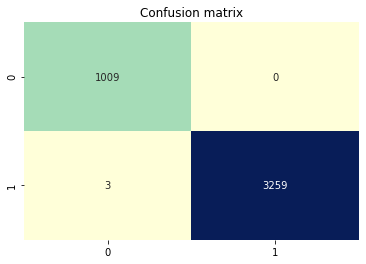

In [10]:
NB_classifier = train_model(naive_bayes.MultinomialNB())

#### Linear classifier

model accuracy: 0.999


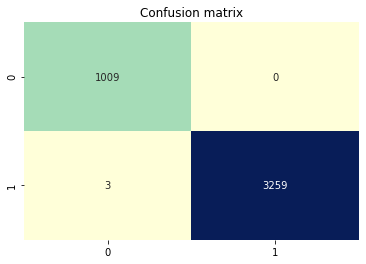

In [11]:
LR_classifier = train_model(linear_model.LogisticRegression())

#### SVM

model accuracy: 1.0


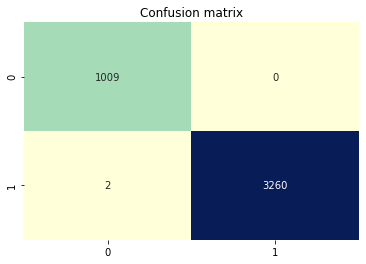

In [18]:
SVM_classifier = train_model(svm.SVC())

#### Random Forest

model accuracy: 0.999


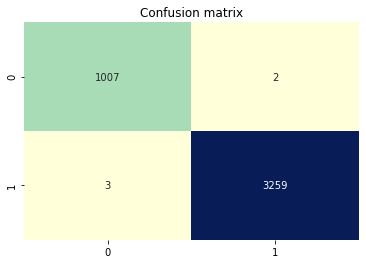

In [13]:
RF_classifier = train_model(RandomForestClassifier())

#### Gradient boosting

LR: 0.1,  n_estimators: 100
model accuracy: 0.991


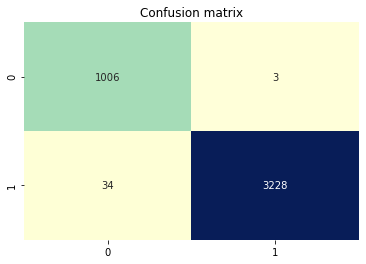

LR: 0.1,  n_estimators: 500
model accuracy: 0.998


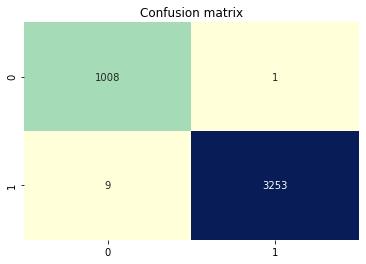

LR: 0.01,  n_estimators: 100
model accuracy: 0.964


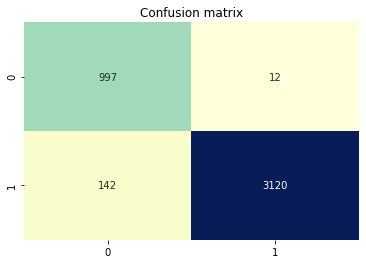

LR: 0.01,  n_estimators: 500
model accuracy: 0.982


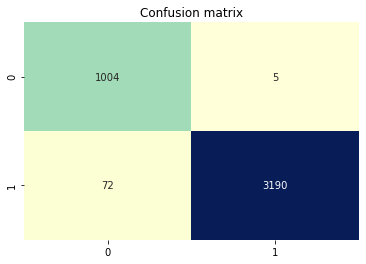

In [14]:
learning_rates = [0.1, 0.01]
n_estimators = [100, 500]

for lr in learning_rates:
    for n in n_estimators:
        print(f"LR: {lr},  n_estimators: {n}")
        RF_classifier = train_model(GradientBoostingClassifier(learning_rate=lr,
                                                      n_estimators=n))

#### Save the model
* as the SVM classifier performs better than the others, we will save it

In [15]:
save_classifier(SVM_classifier)